# Tabu Search

Tabu search (TS) is an iterative neighborhood search algorithm, where the neighborhood changes dynamically. TS enhances local search by actively avoiding points in the search space already visited. By avoiding already visited points, loops in search trajectories are avoided and local optima can be escaped. TS can be considered as the combination of local search (LS) and memory structures. The main feature of TS is the use of an explicit memory. Uses of memory have two goals: to prevent the search from revisiting previously visited solutions and to explore the unvisited areas of the solution space.


TBD…


## Example: Tabu Search for TSP

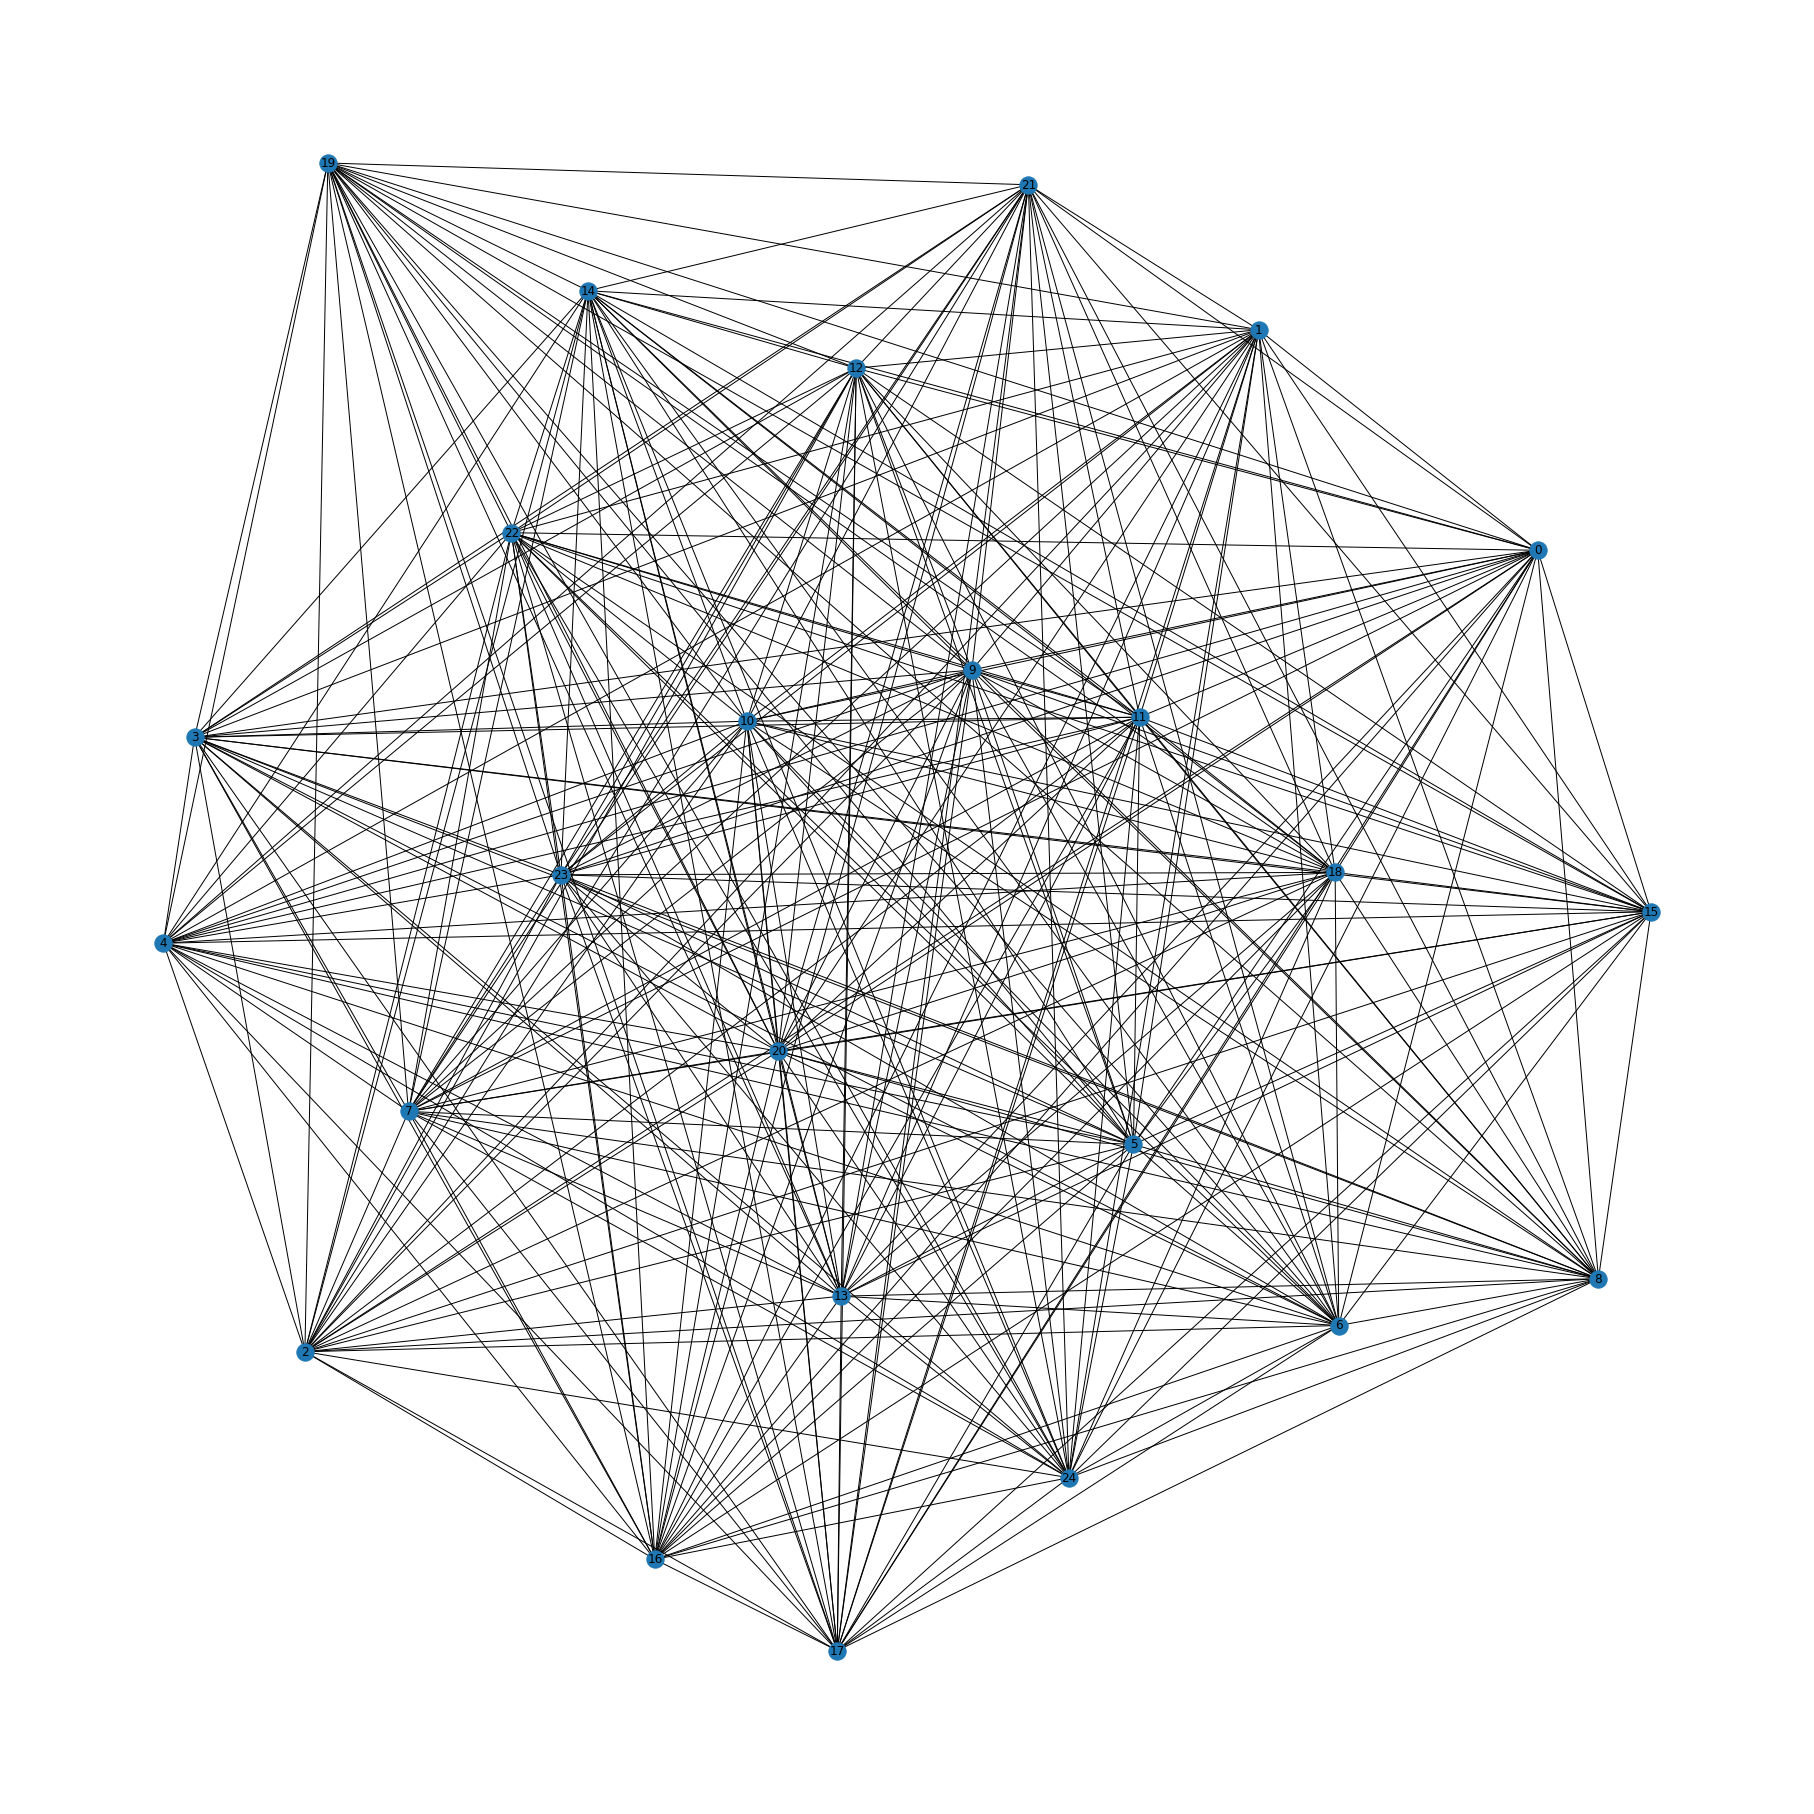

In [6]:
# Initialize the graph
import networkx as nx
import random
import matplotlib.pyplot as plt
import math

G = nx.complete_graph(25)
for (u,v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)

plt.figure(figsize=(25,25))
nx.draw(G, with_labels=True)
plt.show()

In [7]:
# Define a function to calculate the tour cost
def cost_of_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        cost += G[u][v]['weight']
    cost += G[len(tour) - 1][0]['weight']
    return cost

In [8]:
# Initialize a random solution, and its cost
initial_solution = [*G.nodes()]
random.shuffle(initial_solution)
initial_cost = cost_of_tour(G,initial_solution)
print(initial_solution)
print(initial_cost)

[12, 13, 3, 6, 5, 14, 1, 18, 2, 11, 20, 15, 0, 24, 17, 16, 19, 23, 10, 4, 21, 22, 8, 7, 9]
139


In [9]:
def get_best_neighbour(G, tour, tabu_history, tabu_limit, aspiration):
    best_neighbour = None
    best_neighbour_cost = math.inf
    # generate a list of all possible neighbours
    # a neighbour is just swapping the position of two nodes within the tour
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if i == j: continue

            # Swap the ith and jth nodes
            tmp_route = tour.copy()
            tmp = tmp_route[i]
            tmp_route[i] = tmp_route[j]
            tmp_route[j] = tmp
            tmp_cost = cost_of_tour(G,tmp_route)

            # This route is tabu, check aspiration
            if tuple(tmp_route) in tabu_history:
                if tabu_history[tuple(tmp_route)] > 0:
                    if tabu_history[tuple(tmp_route)] > aspiration:
                        continue

            
            if tmp_cost < best_neighbour_cost:
                best_neighbour_cost = tmp_cost
                best_neighbour = tmp_route
                tabu_history[tuple(best_neighbour)] = tabu_limit
        
    return best_neighbour

In [10]:
def tabu_search(G, initial_solution, num_iter, tabu_history, tabu_limit, aspiration):
    best_solution = initial_solution
    best_cost = cost_of_tour(G, best_solution)
    states = []
    for _ in range(num_iter):

        # Reduce counter for all tabu
        for x in tabu_history:
            tabu_history[x] = max(tabu_history[x]-1, 0)
        best_solution = get_best_neighbour(G,best_solution, tabu_history, tabu_limit, aspiration)
        best_cost = cost_of_tour(G, best_solution)
        states.append(best_cost)
    return best_solution, best_cost, states

[12, 13, 18, 9, 22, 14, 6, 19, 2, 11, 4, 0, 3, 23, 17, 16, 21, 10, 24, 5, 20, 1, 8, 7, 15]
31


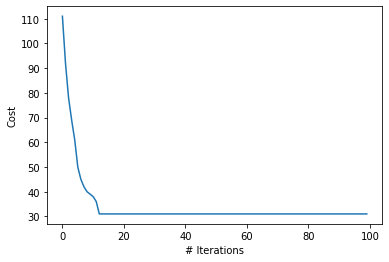

In [11]:
# Initialize some parameters
aspiration = 2
tabu_history = {}
num_iterations = 100
tabu_limit = 5

best_solution, best_cost, states = tabu_search(G, initial_solution, num_iterations, tabu_history, tabu_limit, aspiration)
print(best_solution)
print(best_cost)
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()

## Example: Tabu Search for Routing Problem

We can also use Tabu Search for our University of Toronto routing problem, however we will need to define some new functions.

In [12]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node, randomized_search, cost
from smart_mobility_utilities.viz import draw_route

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

In [13]:
# Initialize a random solution, and its cost
initial_solution = randomized_search(G, origin.osmid, destination.osmid)
initial_cost = cost(G,initial_solution)
print("Initial Solution:",initial_solution)
print("Initial cost:",initial_cost)

Initial Solution: [55808290, 304891685, 55808284, 1721866234, 389678268, 4953810915, 389678267, 24960090, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 2557539841, 389678133, 389677909]
Initial cost: 863.339


In [14]:
from smart_mobility_utilities.children import get_children
from tqdm.notebook import tqdm 

def get_best_neighbour_route(G, route, neighbour_limit, tabu_history, tabu_limit, aspiration):
    best_neighbour = None
    best_neighbour_cost = math.inf
    # generate a list of neighbours, limited to neighbour_limit
    neighbours = get_children(G, route, neighbour_limit)
    for child in neighbours:
        child_cost = cost(G,child)
        # This route is tabu, check aspiration
        if tuple(child) in tabu_history:
            if tabu_history[tuple(child)] > 0:
                if tabu_history[tuple(child)] > aspiration:
                    continue

        
        if child_cost < best_neighbour_cost:
            best_neighbour_cost = child_cost
            best_neighbour = child
            tabu_history[tuple(best_neighbour)] = tabu_limit
        
    return best_neighbour

In [15]:
def tabu_search_route(G, initial_solution, num_iter, neighbour_limit, tabu_history, tabu_limit, aspiration):
    best_solution = initial_solution
    best_cost = cost(G, best_solution)
    states = []
    for _ in tqdm(range(num_iter)):
        # Reduce counter for all tabu
        for x in tabu_history:
            tabu_history[x] = max(tabu_history[x]-1, 0)
            
        best_solution = get_best_neighbour_route(G,best_solution, neighbour_limit, tabu_history, tabu_limit, aspiration)
        best_cost = cost(G, best_solution)
        states.append(best_cost)
    return best_solution, best_cost, states

  0%|          | 0/50 [00:00<?, ?it/s]

[55808290, 55808177, 55808169, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 24959523, 50885177, 389677947, 2143489692, 2480712846, 389678140, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909]
846.958


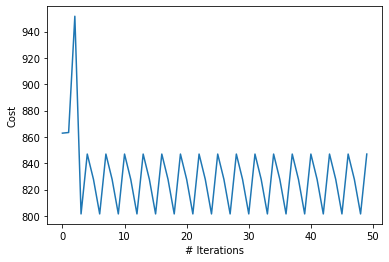

In [18]:
# Initialize some parameters
aspiration = 2
tabu_history = {}
num_iterations = 50
tabu_limit = 5
neighbour_limit = 50 # Because we can generate a very large number of neighbours, we need to set a limit

best_solution, best_cost, states = tabu_search_route(
    G,
    initial_solution,
    num_iterations,
    neighbour_limit,
    tabu_history,
    tabu_limit,
    aspiration,
)
print(best_solution)
print(best_cost)
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()
